# Amazon Comprehend



This notebook guides you through the Amazon Comprehend Features discovery and proposes a deep dive building your own custom classifier.

<a id=TOC></a>
1. [Introduction](#Introduction)
1. [Tips](#Tips)
1. [Amazon Comprehend out of the box](#ComprehendFeatures)
    1. [Features](#Features)
    1. [Real-time analysis explorer](#Explorer)
    1. [Calling APIs](#CallingAPIs)
        1. [Initialization](#Initialization)
        1. [Language Detection](#LanguageDetection)
        1. [Sentiment Analysis](#SentimentAnalysis)
        1. [Syntax Analysis](#SyntaxAnalysis)
        1. [Entities Detection](#EntitiesDetection)
        1. [Key Phrases Extraction](#KeyPhrasesExtraction)
        1. [Batching](#Batching)
        1. [Cost](#Cost)
        1. [Other Features](#OtherFeatures)
    1. [Cleanup](#Cleanup)
1. [Building a custom classifier](#BuildingACustomClassifier)
    1. [Process Overview](#ProcessOverview)
    1. [Initialization](#InitializationCustomClassifier)
    1. [S3 bucket and IAM role creation](#BucketAndRole)
    1. [Training Dataset preparation](#TrainingDataset)
    1. [Custom Classifier training](#TrainingCustomClassifier)
    1. [Batch Analysis](#BatchAnalysisCustomClassifier)
        1. [Test preparation](#TestPreparation)
        1. [Classification](#ClassificationBatch)
    1. [Real-Time Analysis](#RealtimeAnalysisCustomClassifier)
        1. [Endpoint creation](#EndpointCreation)
        1. [Real-Time Custom Classification](#RunningEndpointClassification)
        1. [Endpoint public API](#OpeningEndpoint)
    1. [Cleanup](#CleanupCustomClassifier)
    1. [Cost](#CostCustomClassifier)
1. [What's next](#WhatsNext)
    1. [Auto Scale your Amazon Comprehend endpoints](#AutoScaling)
    1. [Amazon Comprehend Medical](#Medical)
    1. [AWS Solutions using Amazon Comprehend](#Solutions)
        1. [Analyzing Text with Amazon Elasticsearch Service and Amazon Comprehend](#SolutionESComprehend)
        1. [Document Understanding Solution](#SolutionDocumentUnderstanding)

## Introduction
<a id="Introduction"></a>

*([back to top](#TOC))*

[Amazon Comprehend](https://aws.amazon.com/comprehend/) is a natural language processing (NLP) service that uses machine learning (ML) to find insights and relationships in texts. Amazon Comprehend identifies the language of the text; extracts key phrases, places, people, brands, or events; and understands how positive or negative the text is. For more information about everything Amazon Comprehend can do, see [Amazon Comprehend Features](https://aws.amazon.com/comprehend/features/).

You may need out-of-the-box NLP capabilities tied to your needs without having to lead a research phase. This would allow you to recognize entity types and perform document classifications that are unique to your business, such as recognizing industry-specific terms and triaging customer feedback into different categories.

Amazon Comprehend is a perfect match for these use cases. In November 2018, Amazon Comprehend added the ability for you to train it to recognize custom entities and perform custom classification. For more information on building custom entities, please see [Build Your Own Natural Language Models on AWS (no ML experience required)](https://aws.amazon.com/blogs/machine-learning/build-your-own-natural-language-models-on-aws-no-ml-experience-required/), this notebook is partially based on the blog post [Building a custom classifier using Amazon Comprehend](https://aws.amazon.com/blogs/machine-learning/building-a-custom-classifier-using-amazon-comprehend/).

*Notes*: `boto3`, the Python SDK for AWS, is used in the different examples of this notebook. It is already installed if you are executing this Notebook from a Sagemaker Notebook environment. This notebook and associated resources (SAM template and SAM application code) are available [here](https://github.com/hervenivon/aws-experiments-comprehend-custom-classifier).

## Tips
<a id="Tips"></a>

The main tip - if you are new to Python Notebooks - `SHIFT` + `ENTER` will execute a code cell and go to the next one.

## Amazon Comprehend out of the box
<a id="ComprehendFeatures"></a>

*([back to top](#TOC))*

The following section covers Amazon Comprehend features which don't require custom training.

### Features
<a id="Features"></a>

Amazon Comprehend support the following features out of the box across different languages including English, German, Chinese, Spanish, French and others.

| Feature                | Supported Languages                                                              |
|------------------------|----------------------------------------------------------------------------------|
| Language Detection     | [Full list](https://docs.aws.amazon.com/comprehend/latest/dg/how-languages.html) |
| Sentiment Analysis     | All supported languages                                                          |
| Syntax Analysis        | German, English, Spanish, French, Italian, and Portuguese.                       |
| Entities Detection     | All supported languages.                                                         |
| Key Phrases Extraction | All supported languages.                                                         |
| Topic Modeling         | Not dependent on the language.                                                   |
| PII detection          | English.                                                                         |

*For a detailed and updated list, please refer to [supported Languages documentation](https://docs.aws.amazon.com/comprehend/latest/dg/supported-languages.html).*



### Real-time analysis explorer
<a id="Explorer"></a>

Open the [console](https://console.aws.amazon.com/comprehend/v2/home?region=us-east-1#) and click on "**Launch Amazon Comprehend**". You will get an example and interactive results for inspection.

Please change the text at will.

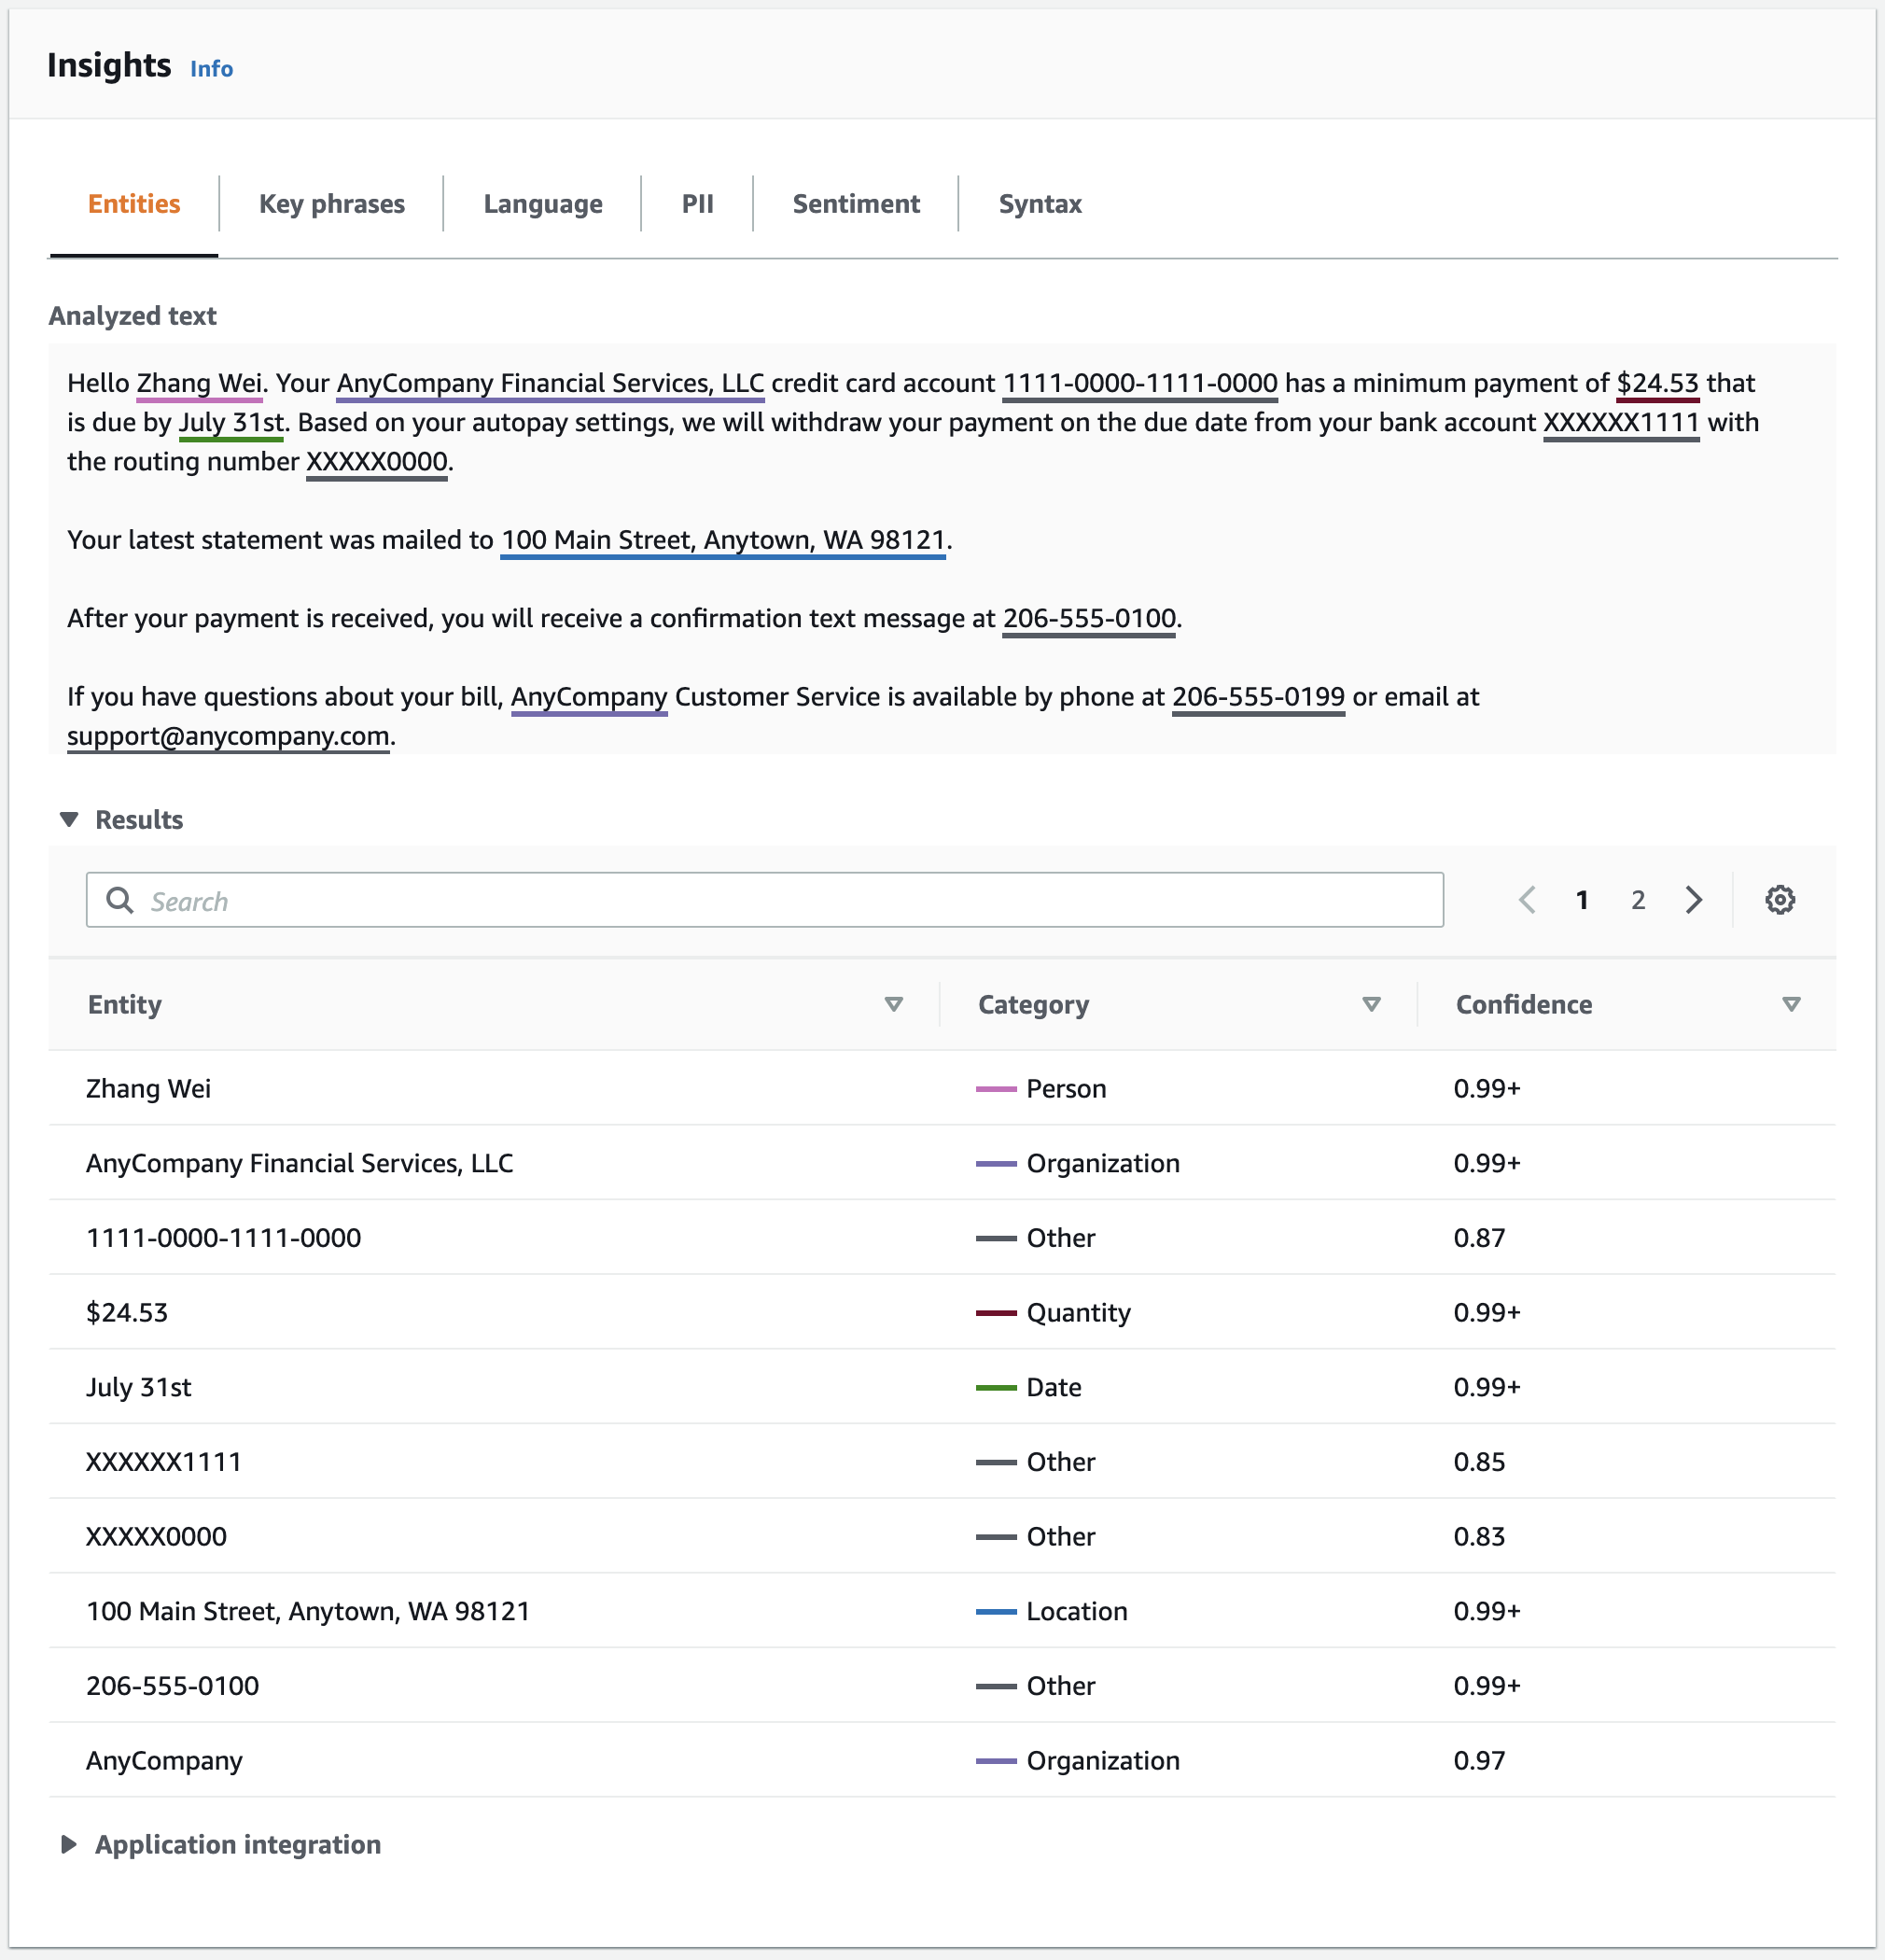

From here on, you will use `python` and the `boto3` library to interact with Amazon Comprehend. You can also do that from the [command line interface](https://docs.aws.amazon.com/cli/latest/reference/comprehend/index.html) or other languages such as [javascript](https://docs.aws.amazon.com/AWSJavaScriptSDK/latest/AWS/Comprehend.html), [go](https://docs.aws.amazon.com/sdk-for-go/api/service/comprehend/), [php](https://docs.aws.amazon.com/aws-sdk-php/v3/api/class-Aws.Comprehend.ComprehendClient.html), [ruby](https://docs.aws.amazon.com/sdk-for-ruby/v3/api/Aws/Comprehend/Client.html), etc.

### Calling APIs
<a id="CallingAPIs"></a>

In this section, you are going to call the APIs from the Python SDK, with several examples.

#### Initialization

In [222]:
import boto3
import locale
import math
from datetime import date
from IPython.display import JSON

# Init the Amazon Comprehend client with boto3
client = boto3.client('comprehend')

# Generate current date in French
locale.setlocale(locale.LC_TIME, 'fr_FR')
current_date_str = date.today().strftime('%A %-d %B %Y')

# The sentence you are going to analyze with Amazon Comprehend out of the box features
text = 'Aujourd\'hui, {} est une belle journée pour découvrir les services d\'intelligence artificielle destinés aux développeurs qu\'offre AWS. Je serai votre hôte pour vous faire découvrir Amazon Comprehend. Hervé Nivon. 😊'.format(current_date_str)
print(text)

Aujourd'hui, mercredi 14 octobre 2020 est une belle journée pour découvrir les services d'intelligence artificielle destinés aux développeurs qu'offre AWS. Je serai votre hôte pour vous faire découvrir Amazon Comprehend. Hervé Nivon. 😊


#### Language detection
<a id="LanguageDetection"></a>

The Language Detection API automatically identifies text written in over 100 languages and returns the dominant language with a confidence score to support that decision. For a complete list of supported languages, please refer to the [documentation](https://docs.aws.amazon.com/comprehend/latest/dg/how-languages.html).

In [223]:
response = client.detect_dominant_language(
    Text=text
)
lang_code = response['Languages'][0]['LanguageCode']
lang_score = response['Languages'][0]['Score']

print('Dominant Language Code: "{}"'.format(lang_code))
print('Score: {0:.{1}f}'.format(lang_score, 3))

Dominant Language Code: "fr"
Score: 0.996


#### Sentiment Analysis
<a id="SentimentAnalysis"></a>

The Sentiment Analysis API returns the overall sentiment of a text (Positive, Negative, Neutral, or Mixed).

In [240]:
response = client.detect_sentiment(
    Text=text,
    LanguageCode=lang_code
)

sentiments = ['Positive', 'Negative', 'Neutral', 'Mixed']

print('Text: {}\n'.format(text))
print('Sentiment:\t{}'.format(response['Sentiment']))
print('Scores:')
for sentiment in sentiments:
    print('• {0}:\t{1:.{2}f}'.format(sentiment, response['SentimentScore'][sentiment], 3))

Text: Aujourd'hui, mercredi 14 octobre 2020 est une belle journée pour découvrir les services d'intelligence artificielle destinés aux développeurs qu'offre AWS. Je serai votre hôte pour vous faire découvrir Amazon Comprehend. Hervé Nivon. 😊

Sentiment:	POSITIVE
Scores:
• Positive:	0.712
• Negative:	0.000
• Neutral:	0.288
• Mixed:	0.000


#### Syntax Analysis
<a id="SyntaxAnalysis"></a>

The Syntax Analysis API enables customers to analyze text using tokenization and Parts of Speech (PoS), and identify word boundaries and labels like nouns and adjectives within the text.

In [241]:
response = client.detect_syntax(
    Text=text,
    LanguageCode=lang_code
)
print('Text: {}\n'.format(text))
JSON(response)

Text: Aujourd'hui, mercredi 14 octobre 2020 est une belle journée pour découvrir les services d'intelligence artificielle destinés aux développeurs qu'offre AWS. Je serai votre hôte pour vous faire découvrir Amazon Comprehend. Hervé Nivon. 😊



<IPython.core.display.JSON object>

#### Entities Detection
<a id="EntitiesDetection"></a>

The Entity Recognition API returns the named entities ("People," "Places," "Locations," etc.) that are automatically categorized based on the provided text.

In [243]:
response = client.detect_entities(
    Text=text,
    LanguageCode=lang_code
)
print('Text: {}\n'.format(text))
JSON(response)

Text: Aujourd'hui, mercredi 14 octobre 2020 est une belle journée pour découvrir les services d'intelligence artificielle destinés aux développeurs qu'offre AWS. Je serai votre hôte pour vous faire découvrir Amazon Comprehend. Hervé Nivon. 😊



<IPython.core.display.JSON object>

#### Key Phrases Extraction
<a id="KeyPhrasesExtraction"></a>

The Keyphrase Extraction API returns the key phrases or talking points and a confidence score to support that this is a key phrase.

In [227]:
response = client.detect_key_phrases(
    Text=text,
    LanguageCode=lang_code
)
print('Text: {}\n'.format(text))
JSON(response)

<IPython.core.display.JSON object>

#### Batch calls
<a id="Batching"></a>

Amazon Comprehend allows you to detect languages, entities, key phrases, sentiment and syntax in bulk. With `boto3`, methods are preceeded by `batch_`. See `Comprehend` client [documentation](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/comprehend.html) for more details.

In the following test, you will perform a batch language detection and sentiment analysis with the following examples:

Example 1:
> Dear solutions architects,
> 
> Is there a way for AWS to analyze text with simple API calls?
> 
> I would like to prototype that as fast as possible, I have a customer meeting tomorrow.
> Help required,
>
> You can join me on +33 6 33 33 33 33
>
> John Doe

Example 2:
> I love your SUPER PRODUCT. Nevertheless, j'ai des besoins qui ne sont pas couverts et j'aimerais les faire remonter. To whom should I speak to?

Example 3:
> “A suspect bit the ear of a 4-year-old police dog and injured the animal’s neck during a chase and arrest, police said today. The dog, Rex, was on patrol with Constable Philip Rajah in the Natal provincial capital during the weekend when they came across two suspicious individuals,” police said. 
> While Rajah searched one man, Rex chased the other and got the worst of it when his quarry turned on the animal and bit him. Rajah had to yank the man off the dog, police said. They said the dog was being treated for a serious neck injury at a veterinary clinic. The man who bit the dog may face a charge of malicious injury to state property.

In [242]:
example_1="""
Dear solutions architects,

Is there a way for AWS to analyze text with simple API calls?

I would like to prototype that as fast as possible, I have a customer meeting tomorrow.

Help required,

You can join me on +33 6 33 33 33 33
John Doe
"""

example_2="""
I love your SUPER PRODUCT. 

Nevertheless, j'ai des besoins qui ne sont pas couverts et j'aimerais les faire remonter. 

To whom should I speak to?
"""

example_3="""
“A suspect bit the ear of a 4-year-old police dog and injured the animal’s neck during a chase and arrest, police said today. The dog, Rex, was on patrol with Constable Philip Rajah in the Natal provincial capital during the weekend when they came across two suspicious individuals,” police said. 
While Rajah searched one man, Rex chased the other and got the worst of it when his quarry turned on the animal and bit him. Rajah had to yank the man off the dog, police said. They said the dog was being treated for a serious neck injury at a veterinary clinic. The man who bit the dog may face a charge of malicious injury to state property.
"""

examples_ld=[example_1, example_2, example_3, text]

response=client.batch_detect_dominant_language(
    TextList=examples_ld
)

JSON(response)

<IPython.core.display.JSON object>

In [229]:
examples_sa=[example_1, example_3]

response=client.batch_detect_sentiment(
    TextList=examples_sa,
    LanguageCode="en"
)

JSON(response)

<IPython.core.display.JSON object>

`example_3` originates from an Associated Press data set. It was used in a [blog post](https://medium.com/@julsimon/a-quick-look-at-natural-language-processing-with-amazon-comprehend-238b8d9ec11d) righ after Amazon Comprehend announcement at re:invent 2017.

At that time it scored at 0.22 negative with Amazon Comprehend. It currently scores 0.48 negative. Which is a considerable improvement from Rex point of view!

### Cost
<a id="Cost"></a>

On October 2020, Amazon Comprehend [pricing](https://aws.amazon.com/comprehend/pricing/) per unit for the us-east-1 region is (Up to 10M units, 1 unit is 100 characters):

- Key Phrase Extraction: \$0.0001
- Sentiment Analysis: \$0.0001
- Entity Recognition: \$0.0001
- Language Detection: \$0.0001
- Syntax Analysis: \$0.00005

Therefore, excluding Amazon Comprehend Free Tier (50k units of text):

In [230]:
unit_text=math.ceil(len(text)/100)
unit_total_ld=math.ceil(len(''.join(examples_ld))/100)
unit_total_sa=math.ceil(len(''.join(examples_sa))/100)

print('Total cost ${0:.{1}f}'.format(
    (0.0001 * 4 + 0.00005) * unit_text + 
    0.0001 * unit_total_ld + 
    0.0001 * unit_total_sa, 5))

Total cost $0.00355


#### Other Features
<a id="OtherFeatures"></a>

Amazon Comprehend also provides [Topic Modeling](https://docs.aws.amazon.com/comprehend/latest/dg/topic-modeling.html) (Detection of common themes across documents) and [Personnally Identifiable Information](https://docs.aws.amazon.com/comprehend/latest/dg/how-pii.html) (PII, only in English as of October 2020).

### Cleanup
<a id="Cleanup"></a>

There is nothing to clean in this section.

## Building a custom classifier
<a id="BuildingACustomClassifier"></a>
*([back to top](#TOC))*

In addition to features listed in the [previous section](#Features), Amazon Comprehend also allows you to create your very own Custom Classifier and Custom Entity Recognizer.

In the following step, you are going to build a custom classifier based on an open dataset.

*Note: you can refer to [Building a custom classifier using Amazon Comprehend](https://aws.amazon.com/blogs/machine-learning/building-a-custom-classifier-using-amazon-comprehend/) blog post for more details.*

### Process Overview
<a id="ProcessOverview"></a>

In this section of the notebook here a the steps we are going to follow:

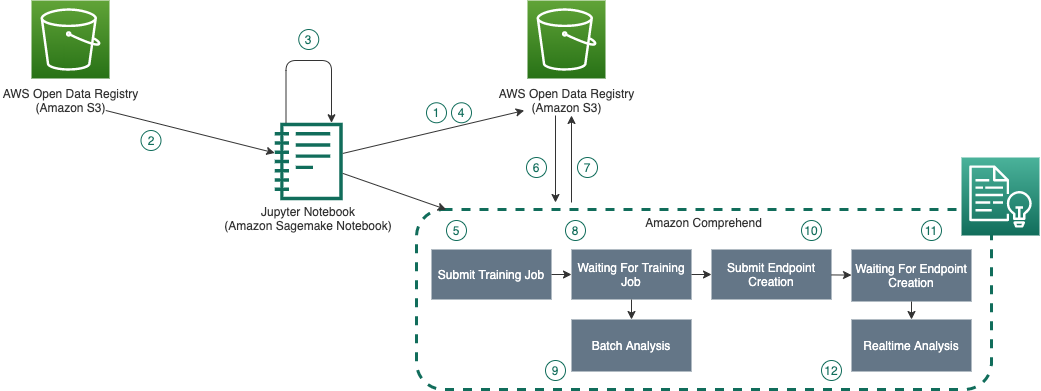

1. Create an S3 bucket and IAM role
1. Download the dataset from Open Registry
1. Prepare the dataset to train Amazon Comprehend custom classification
1. Upload the prepared data to the S3 bucket
1. Submit a training job
1. Amazon Comprehend training job downloads the data from Amazon S3
1. Amazon Comprehend uploads the training result details to Amazon S3
1. Wait for the training job to complete
1. Perform a batch analysis
1. Create a realtime analysis endpoint
1. Wait for the endpoint creation
1. Perform a realtime analysis

### Initialization
<a id="InitializationCustomClassifier"></a>

Before moving onto the next step, there are some initial steps required to setup the notebook.

This notebook requires the following Python packages:

- `boto3` is required to download the open source data and interact with Amazon Comprehend.
- `tarfile` is required to untar 
- `panda` is required to transform the data and make them compatible with Amazon Comprehend Custom Classifier.

In [2]:
import sys
!{sys.executable} -m pip install pandas==1.1.3

import boto3
import json
import logging
import pandas as pd
import random
import tarfile
from IPython.display import JSON
from botocore.exceptions import ClientError

     |████████████████████████████████| 9.5 MB 12.5 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.1
    Uninstalling pandas-1.0.1:
      Successfully uninstalled pandas-1.0.1
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


### S3 bucket and IAM role creation
<a id="BucketAndRole"></a>

Amazon Comprehend needs an Amazon Simple Storage Service (Amazon S3) bucket for training a custom classifier. Amazon Comprehend must be granted permissions that allows it to access that bucket. This is done through IAM.

The following step creates needed bucket, role and policy.

In [3]:
# If a region is not specified, the bucket is created in the S3 default region (us-east-1).
region = boto3.session.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')
bucket_name = 'comprehend-experiment-{}'.format(account_id)

try:
    if region == 'us-east-1':
        s3 = boto3.client('s3')
        s3.create_bucket(Bucket=bucket_name)
    else:
        s3 = boto3.client('s3', region_name=region)
        location = {'LocationConstraint': region}
        s3.create_bucket(Bucket=bucket_name,
                         CreateBucketConfiguration=location)
except ClientError as e:
    print(e)

bucket_arn = 'arn:aws:s3:::{}'.format(bucket_name)



iam = boto3.client('iam')

role_name = 'ComprehendExperimentBucketAccessRole'
role_arn = ''
policy_name = 'ComprehendExperimentDataAccessRolePolicy'
policy_arn = ''

# Principal — defines the entity which can assume this role
trust_relationship_policy_comprehend = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                "Service": "comprehend.amazonaws.com"
            },
            "Action": "sts:AssumeRole"
        }
    ]
}

# This policy grant access to the bucket created previously
policy_s3_comprehend = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "s3:GetObject",
                "s3:PutObject"
            ],
            "Resource": [
                "{}/*".format(bucket_arn)
            ],
            "Effect": "Allow"
        },
        {
            "Action": [
                "s3:ListBucket"
            ],
            "Resource": [
                "{}".format(bucket_arn)
            ],
            "Effect": "Allow"
        }
    ]
}

# Create the role
try:
    create_role_res = iam.create_role(
        RoleName=role_name,
        AssumeRolePolicyDocument=json.dumps(trust_relationship_policy_comprehend),
        Description='Comprehend Experiment Role',
    )
    role_arn = create_role_res['Role']['Arn']
except ClientError as error:
    if error.response['Error']['Code'] == 'EntityAlreadyExists':
        role_arn = 'arn:aws:iam::{0}:role/{1}'.format(account_id, role_name)
    else:
        print('Unexpected error occurred... Role could not be created')
    
# Create the policy
try:
    policy_res = iam.create_policy(
        PolicyName=policy_name,
        PolicyDocument=json.dumps(policy_s3_comprehend)
    )
    policy_arn = policy_res['Policy']['Arn']
except ClientError as error:
    if error.response['Error']['Code'] == 'EntityAlreadyExists':
        policy_arn = 'arn:aws:iam::{0}:policy/{1}'.format(account_id, policy_name)
    else:
        print('Unexpected error occurred... hence cleaning up')
        iam.delete_role(
            RoleName= role_name
        )

# Attach the policy to the role
try:
    policy_attach_res = iam.attach_role_policy(
        RoleName=role_name,
        PolicyArn=policy_arn
    )
except ClientError as error:
    print('Unexpected error occurred... hence cleaning up')
    iam.delete_role(
        RoleName=role_name
    )

print('Role ARN: "{}"'.format(role_arn))
print('Policy ARN: "{}"'.format(policy_arn))
print('Bucket ARN: "{}"'.format(bucket_arn))


Role ARN: "arn:aws:iam::313506734225:role/ComprehendExperimentBucketAccessRole"
Policy ARN: "arn:aws:iam::313506734225:policy/ComprehendExperimentDataAccessRolePolicy"
Bucket ARN: "arn:aws:s3:::comprehend-experiment-313506734225"


### Training Dataset preparation
<a id="TrainingDataset"></a>

This post uses the Yahoo answers corpus cited in the paper [Text Understanding from Scratch](https://arxiv.org/abs/1502.01710) by Xiang Zhang and [Yann LeCun](https://twitter.com/ylecun). This dataset is available on the [AWS Open Data Registry](https://registry.opendata.aws/fast-ai-nlp/).

The Registry of Open Data on AWS makes it easy to find datasets made publicly available through AWS services. [Browse](https://registry.opendata.aws/) available data and learn how to register your own datasets.

You can also use your own dataset. The custom classifier can be trained in either multi-class or multi-label mode. Multi-class mode associates only a single class with each document. Multi-label mode associates more than one class with a document. The training data formats are different for each mode as well.

The Yahoo answers corpus is a multi-class dataset: you have a single class associated to each document.

It is [recommended](https://docs.aws.amazon.com/comprehend/latest/dg/how-document-classification-training-data.html) that you train the model with 50 or more training documents for each class. While a minimum of 10 training documents for each class is required, you get better accuracy with more documents. The total size of the training documents must be less than 5 GB with no more than 1,000,000 documents.

For more information, see [Training a Custom Classifier](https://docs.aws.amazon.com/comprehend/latest/dg/how-document-classification-training.html).

In the following section you download the dataset from the Registry of Open Data.

In [4]:
dataset_bucket_name = 'fast-ai-nlp'
dataset_object_name = 'yahoo_answers_csv.tgz'

s3 = boto3.client('s3')
with open(dataset_object_name, 'wb') as f:
    s3.download_fileobj(dataset_bucket_name, dataset_object_name, f)
    
tar = tarfile.open(dataset_object_name)
tar.extractall()
tar.close()

!ls -lah yahoo_answers_csv

total 742M
drwx------ 2 ec2-user ec2-user 4.0K Feb 14  2018 .
drwxrwxr-x 8 ec2-user ec2-user 4.0K Oct 16 10:05 ..
-rw------- 1 ec2-user ec2-user  183 Feb 14  2018 classes.txt
-rw------- 1 ec2-user ec2-user 1.8K Feb 14  2018 readme.txt
-rw------- 1 ec2-user ec2-user  31M Feb 14  2018 test.csv
-rw------- 1 ec2-user ec2-user 712M Feb 14  2018 train.csv


This downloads the dataset and extract it to the `yahoo_answers_csv` folder, which contains the following files:

- `classes.txt`
- `readme.txt`
- `test.csv`
- `train.csv`

The files `train.csv` and `test.csv` contain the training samples as comma-separated values.

There are four columns corresponding to: 

- class index (1 to 10), 
- question title,
- question content, 
- and best answer.

The text fields are escaped using double quotes (`"`), and any internal double quote is escaped by two double quotes (`""`). New lines are escaped by a backslash followed with an "n" character, that is `\n`.

In [5]:
src_train_file='yahoo_answers_csv/train.csv'
src_test_file='yahoo_answers_csv/test.csv'

with open(src_train_file) as myfile:
    head = [next(myfile) for x in range(5)]

JSON(head)

<IPython.core.display.JSON object>

The file `classes.txt` contains the available labels.

The `train.csv` file contains 1,400,000 lines and `test.csv` contains 60,000 lines. Amazon Comprehend uses between 10–20% of the documents submitted for training to test the custom classifier.

The following loads the dataset and demonstrates that the data is evenly distributed:

In [6]:
# Loading the train set
trainFrame = pd.read_csv(src_train_file, header=None)
print('Number of documents: {}'.format(len(trainFrame.index)))

# Count unique values 
trainFrame[0].value_counts()

Number of documents: 1400000


10    140000
9     140000
8     140000
7     140000
6     140000
5     140000
4     140000
3     140000
2     140000
1     140000
Name: 0, dtype: int64

A minimum of 10 documents for each class is required for the training with less than 5GB and no more than 1,000,000 documents. Also, during training, Amazon Comprehend uses between [10 and 20 percent of the training documents](https://docs.aws.amazon.com/comprehend/latest/dg/testing-the-model.html) to test the custom classifier model.

In this case, that is still a lot of documents dedicated for the training.

You are using data in `train.csv` to train our Amazon Comprehend custom classifier, and use `test.csv` to perform validation and see how well our custom model performs.

First, let's remove the exceeding documents.

*Note: `MAXITEMPERCLASS` represent the number of items to keep per class. If you want to speed up the experiment, you can reduce this number. 10 is the minimum.*

In [7]:
MAXITEMPERCLASS=100000
# Keeping MAXITEMPERCLASS for each class
for i in range(1, 11):
    num = len(trainFrame[trainFrame[0] == i])
    dropnum = num - MAXITEMPERCLASS
    indextodrop = trainFrame[trainFrame[0] == i].sample(n=dropnum).index
    trainFrame.drop(indextodrop, inplace=True)

print('Number of documents: {}'.format(len(trainFrame.index)))

# Count unique values 
trainFrame[0].value_counts()

Number of documents: 1000000


10    100000
9     100000
8     100000
7     100000
6     100000
5     100000
4     100000
3     100000
2     100000
1     100000
Name: 0, dtype: int64

For training, [the file format must conform to the following requirements](https://docs.aws.amazon.com/comprehend/latest/dg/how-document-classification-training-multi-class.html):

- File must contain one class and one text per line – 2 columns
- No header
- Format must be UTF-8 with carriage return `\n`.

Classes can be any valid UTF-8 string. It is recommanded that classes are clear and don't overlap in meaning. They can have white space, and the can consist of multiple words connected by underscores or hyphens.

The following table contains the formatted labels proposed for the training.

| Index | Original               | Comprehend training      |
|-------|------------------------|--------------------------|
| 1     | Society & Culture      | SOCIETY_AND_CULTURE      |
| 2     | Science & Mathematics  | SCIENCE_AND_MATHEMATICS  |
| 3     | Health                 | HEALTH                   |
| 4     | Education & Reference  | EDUCATION_AND_REFERENCE  |
| 5     | Computers & Internet   | COMPUTERS_AND_INTERNET   |
| 6     | Sports                 | SPORTS                   |
| 7     | Business & Finance     | BUSINESS_AND_FINANCE     |
| 8     | Entertainment & Music  | ENTERTAINMENT_AND_MUSIC  |
| 9     | Family & Relationships | FAMILY_AND_RELATIONSHIPS |
| 10    | Politics & Government  | POLITICS_AND_GOVERNMENT  |

The following step prepares the full dataset for the training.

In [7]:
mapping = {
    1:'SOCIETY_AND_CULTURE',
    2:'SCIENCE_AND_MATHEMATICS',
    3:'HEALTH',
    4:'EDUCATION_AND_REFERENCE',
    5:'COMPUTERS_AND_INTERNET',
    6:'SPORTS',
    7:'BUSINESS_AND_FINANCE',
    8:'ENTERTAINMENT_AND_MUSIC',
    9:'FAMILY_AND_RELATIONSHIPS',
    10:'POLITICS_AND_GOVERNMENT'
}

# Applying mapping from numerical codes into classes
trainFrame[0] = trainFrame[0].apply(mapping.get)
trainFrame.head(n=5)

,0,1,2,3
0,COMPUTERS_AND_INTERNET,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,SPORTS,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,HEALTH,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,BUSINESS_AND_FINANCE,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
5,COMPUTERS_AND_INTERNET,What's the best way to clean a keyboard?,I have very small stuff stuck under my keyboar...,"There are commercial kits available, but a can..."


In [8]:
# Joining "Question title", "question content", and "best answer".
trainFrame['document'] = trainFrame[trainFrame.columns[1:]].apply(
    lambda x: ' \\n '.join(x.dropna().astype(str)),
    axis=1
)
trainFrame.head(n=5)

,0,1,2,3,document
0,COMPUTERS_AND_INTERNET,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...,why doesn't an optical mouse work on a glass t...
1,SPORTS,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...,What is the best off-road motorcycle trail ? \...
2,HEALTH,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...,What is Trans Fat? How to reduce that? \n I he...
3,BUSINESS_AND_FINANCE,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...,How many planes Fedex has? \n I heard that it ...
5,COMPUTERS_AND_INTERNET,What's the best way to clean a keyboard?,I have very small stuff stuck under my keyboar...,"There are commercial kits available, but a can...",What's the best way to clean a keyboard? \n I ...


In [9]:
# Keeping only the class and the text aggregation
trainFrame.drop([1, 2, 3], axis=1, inplace=True)
trainFrame.head(n=5)

,0,document
0,COMPUTERS_AND_INTERNET,why doesn't an optical mouse work on a glass t...
1,SPORTS,What is the best off-road motorcycle trail ? \...
2,HEALTH,What is Trans Fat? How to reduce that? \n I he...
3,BUSINESS_AND_FINANCE,How many planes Fedex has? \n I heard that it ...
5,COMPUTERS_AND_INTERNET,What's the best way to clean a keyboard? \n I ...


In [10]:
# Cleaning up the data
# '<br />' to be changed into ' \\n'
# '\\n' without space to be replaced into ' \\n '
trainFrame['document'] = trainFrame['document'].str.replace('<br />', ' \\n', regex=False)
trainFrame['document'] = trainFrame['document'].str.replace('\\n', '\\n ', regex=False)
trainFrame.head(n=5)

,0,document
0,COMPUTERS_AND_INTERNET,why doesn't an optical mouse work on a glass t...
1,SPORTS,What is the best off-road motorcycle trail ? \...
2,HEALTH,What is Trans Fat? How to reduce that? \n I h...
3,BUSINESS_AND_FINANCE,How many planes Fedex has? \n I heard that it...
5,COMPUTERS_AND_INTERNET,What's the best way to clean a keyboard? \n I...


In [11]:
comprehend_train_file='comprehend-train.csv'

# Writing csv file
trainFrame.to_csv(path_or_buf=comprehend_train_file,
                  header=False,
                  index=False,
                  encoding='utf-8')

!ls -lah comprehend-train.csv
!head -5 comprehend-train.csv

-rw-rw-r-- 1 ec2-user ec2-user 527M Oct 15 01:33 comprehend-train.csv
COMPUTERS_AND_INTERNET,"why doesn't an optical mouse work on a glass table? \n  or even on some surfaces? \n  Optical mice use an LED and a camera to rapidly capture images of the surface beneath the mouse.  The infomation from the camera is analyzed by a DSP (Digital Signal Processor) and used to detect imperfections in the underlying surface and determine motion. Some materials, such as glass, mirrors or other very shiny, uniform surfaces interfere with the ability of the DSP to accurately analyze the surface beneath the mouse.  \n Since glass is transparent and very uniform, the mouse is unable to pick up enough imperfections in the underlying surface to determine motion.  Mirrored surfaces are also a problem, since they constantly reflect back the same image, causing the DSP not to recognize motion properly. When the system is unable to see surface changes associated with movement, the mouse will not work properl

In the following cell, you will push the prepared file to the bucket you created earlier.

In [12]:
s3 = boto3.client('s3')

train_object_name = 'train/' + comprehend_train_file
response = s3.upload_file(comprehend_train_file, bucket_name, train_object_name)
train_object_name_s3uri = 's3://{0}/{1}'.format(bucket_name, train_object_name)

print('File uploaded to s3, uri: ' + train_object_name_s3uri)

File uploaded to s3, uri: s3://comprehend-experiment-313506734225/train/comprehend-train.csv


### Custom Classifier training
<a id="TrainingCustomClassifier"></a>

You are now ready to launch the custom text classifier training.

In [13]:
client = boto3.client('comprehend')
region = boto3.session.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

train_output_s3uri = 's3://{0}/train/output/'.format(bucket_name)
document_classifier_name = 'yahoo-answers'
document_classifier_arn = ''
response = None

try:
    response = client.create_document_classifier(
        DocumentClassifierName=document_classifier_name,
        DataAccessRoleArn=role_arn,
        InputDataConfig={
            'DataFormat': 'COMPREHEND_CSV',
            'S3Uri': train_object_name_s3uri
        },
        OutputDataConfig={
            'S3Uri': train_output_s3uri
        },
        LanguageCode='en'
    )
    document_classifier_arn = response['DocumentClassifierArn']
except ClientError as error:
    if error.response['Error']['Code'] == 'ResourceInUseException':
        print('A classifier with the name "{0}" already exists. Hence not creating it.'.format(document_classifier_name))
        document_classifier_arn = 'arn:aws:comprehend:{0}:{1}:document-classifier/{2}'.format(region, account_id, document_classifier_name)
    
print('Document Classifier ARN: ' + document_classifier_arn)

A classifier with the name "yahoo-answers" already exists. Hence not creating it.
Document Classifier ARN: arn:aws:comprehend:us-east-1:313506734225:document-classifier/yahoo-answers


Training is an asynchronous process. You can track the training progress:

In [14]:
import time
from datetime import datetime, timezone

client = boto3.client('comprehend')

response = None
repeat = True
status = ''
submit_datetime = None
end_datetime = None
output_data_config_s3uri = ''

while True:
    response = client.describe_document_classifier(
        DocumentClassifierArn=document_classifier_arn
    )
    status = response['DocumentClassifierProperties']['Status']
    submit_datetime = response['DocumentClassifierProperties']['SubmitTime']
        
    if status in ['SUBMITTED', 'TRAINING', 'DELETING', 'STOP_REQUESTED']: # status is going to change
        end_datetime = datetime.now(timezone.utc)
        if repeat:
            print('.', end = '')
            time.sleep(20)
        else:
            break
    else:
        end_datetime = response['DocumentClassifierProperties']['EndTime']
        break
        
print('Job status: ' + status)
print('Elasped time: {}'.format(end_datetime - submit_datetime))

if status == 'TRAINED':
    output_data_config_s3uri = response['DocumentClassifierProperties']['OutputDataConfig']['S3Uri']
    accuracy = response['DocumentClassifierProperties']['ClassifierMetadata']['EvaluationMetrics']['Accuracy']
    print('Classifier Accuracy: {0:.{1}f}'.format(accuracy, 2))
    print('Output Data Config: {}'.format(output_data_config_s3uri))

Job status: TRAINED
Elasped time: 19:28:11.449000
Output Data Config: s3://comprehend-experiment-313506734225/train/output/313506734225-CLR-bfa9a4fd73f591122a47c5acb828ee57/output/output.tar.gz


When the training is finished, job status move to `'TRAINED'`. 

The training duration may vary; in this case, the training took arround 20 hours for the maximum number of documents allowed (`MAXITEMPERCLASS = 100000` = 1,000,000 rows).

The output for the training on the full dataset indicates that the model has an accuracy of 0.75 — in other words, it correctly identifies 75% of given classes during training test. (This number may vary depending on the filtered items during the dataset reduction).

The following screenshot shows the view from the [console](https://console.aws.amazon.com/comprehend/v2/home?region=us-east-1#classification) (Comprehend > Custom Classification > yahoo-answers).

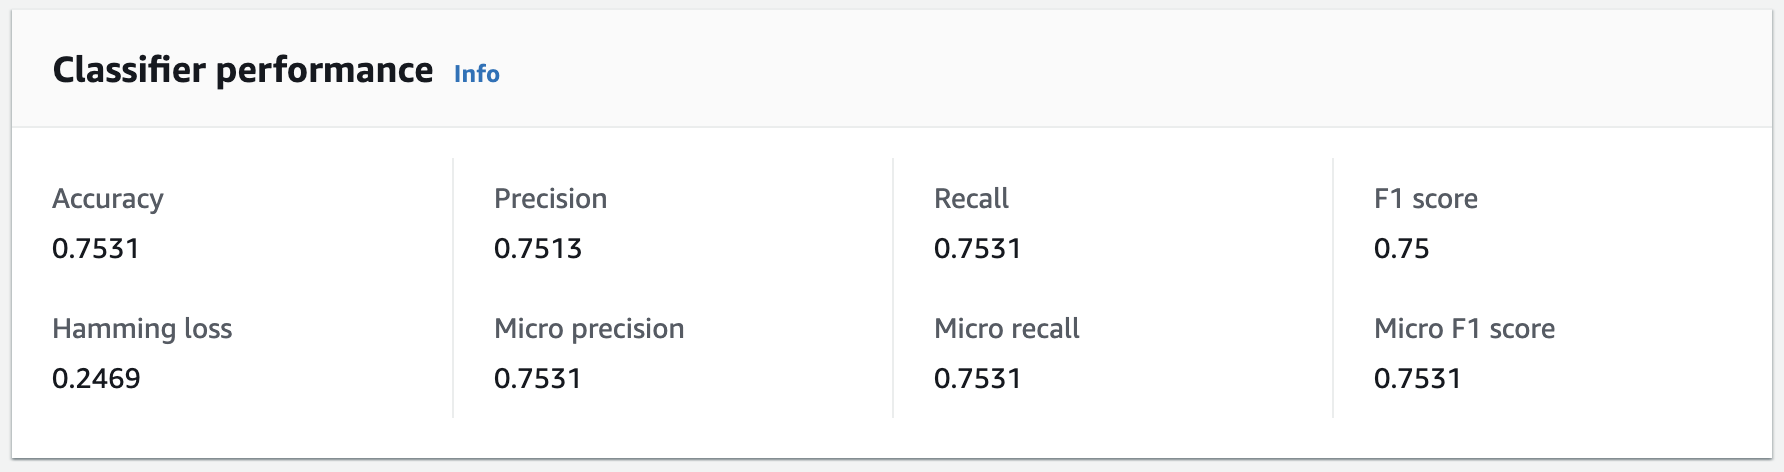

Please refer to the [Custom Classifier Metrics documentation](https://docs.aws.amazon.com/comprehend/latest/dg/cer-doc-class.html) for more details on these metrics.

The training process generates a [Confusion Matrix](https://docs.aws.amazon.com/comprehend/latest/dg/conf-matrix.html) that can help you tweak your training data in order to improve custom model accuracy. In this case, the model is in Multi-Class mode; the individual classes are mutually exclusive and each document is expected to have one and only one label assigned to it. For example, an animal can be a dog or a cat, but not both at the same time.

In [15]:
%%bash -s "$output_data_config_s3uri"
aws s3 cp $1 .
tar xvzf output.tar.gz

download: s3://comprehend-experiment-313506734225/train/output/313506734225-CLR-bfa9a4fd73f591122a47c5acb828ee57/output/output.tar.gz to ./output.tar.gz
output/
output/confusion_matrix.json


Legend:
• 0: BUSINESS_AND_FINANCE
• 1: COMPUTERS_AND_INTERNET
• 2: EDUCATION_AND_REFERENCE
• 3: ENTERTAINMENT_AND_MUSIC
• 4: FAMILY_AND_RELATIONSHIPS
• 5: HEALTH
• 6: POLITICS_AND_GOVERNMENT
• 7: SCIENCE_AND_MATHEMATICS
• 8: SOCIETY_AND_CULTURE
• 9: SPORTS


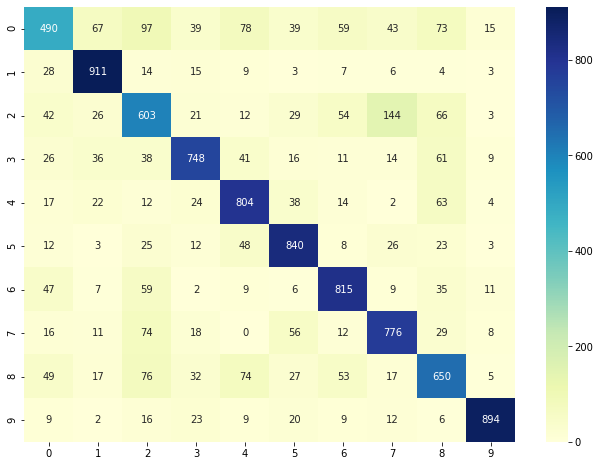

In [16]:
import json
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

confusion_matrix_file = 'output/confusion_matrix.json'
data = None

with open(confusion_matrix_file) as f:
    data = json.load(f)

confusion_matrix = data['confusion_matrix']
df_cm = pd.DataFrame(confusion_matrix, 
                     index = [i for i in "0123456789"],
                     columns = [i for i in "0123456789"])
plt.figure(figsize = (11, 8))
sn.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

print('Legend:')
for i in range(len(data['labels'])):
    print('• {0}: {1}'.format(i, data['labels'][i]))

Once a custom model has been trained, you can either:

- Run an [Asynchronous Classification Job](https://docs.aws.amazon.com/comprehend/latest/dg/how-class-run.html)
- Perform [Real-time Classification Analysis](https://docs.aws.amazon.com/comprehend/latest/dg/custom-sync.html)

### Batch analysis
<a id="BatchAnalysisCustomClassifier"></a>

On top of Real-time analysis, once a custom model has been trained, you can also submit several document at the same time for classification. This will trigger an asynchronous classification job.

#### Test preparation
<a id="TestPreparation"></a>

In the following section, we prepare the data for inference.

In [17]:
# Preparation of the validation set
validationFrame = pd.read_csv(src_test_file, header=None)

# Here, we are limiting to 100 documents to test in order to reduce costs of this demo.
# If you want to test Amazon Comprehend on the full dataset, set MAXITEM to None
# MAXITEM=None
MAXITEM=100

# Keeping MAXITEM
if MAXITEM:
    num = len(validationFrame)
    dropnum = num - MAXITEM
    indextodrop = validationFrame.sample(n=dropnum).index
    validationFrame.drop(indextodrop, inplace=True)
    
validationFrame.head(n=5)

,0,1,2,3
810,7,who is bored and stuck on level one on this ya...,NaN,I am bored & stuck! Can I buy you a beer?
881,7,What is the best way to market a product on a ...,I am wanting to test an idea before I actually...,I'd give the product to 1/2 dozen local high-s...
1590,5,my hair is week and fall always is there speci...,NaN,Try drinking lots of milk. It has vit. D and ...
2478,9,Do you think gay people should be allowed to g...,NaN,No I don't think so! It is not right in Gods e...
3675,4,I want to convert bullet list in a word docume...,Any type of list in word format to html list f...,Why use a macro? Why not just save your word ...


In [18]:
# Joining "Question title", "question content", and "best answer".
validationFrame['document'] = validationFrame[validationFrame.columns[1:]].apply(
    lambda x: ' \\n '.join(x.dropna().astype(str)),
    axis=1
)
validationFrame.head(n=5)

,0,1,2,3,document
810,7,who is bored and stuck on level one on this ya...,NaN,I am bored & stuck! Can I buy you a beer?,who is bored and stuck on level one on this ya...
881,7,What is the best way to market a product on a ...,I am wanting to test an idea before I actually...,I'd give the product to 1/2 dozen local high-s...,What is the best way to market a product on a ...
1590,5,my hair is week and fall always is there speci...,NaN,Try drinking lots of milk. It has vit. D and ...,my hair is week and fall always is there speci...
2478,9,Do you think gay people should be allowed to g...,NaN,No I don't think so! It is not right in Gods e...,Do you think gay people should be allowed to g...
3675,4,I want to convert bullet list in a word docume...,Any type of list in word format to html list f...,Why use a macro? Why not just save your word ...,I want to convert bullet list in a word docume...


In [19]:
# Removing all column but the aggregated one
originalValidationFrame = validationFrame.copy(deep=True)

validationFrame.drop([0, 1, 2, 3], axis=1, inplace=True)
validationFrame.head(n=5)

,document
810,who is bored and stuck on level one on this ya...
881,What is the best way to market a product on a ...
1590,my hair is week and fall always is there speci...
2478,Do you think gay people should be allowed to g...
3675,I want to convert bullet list in a word docume...


In [20]:
# Cleaning up the data
# '<br />' to be changed into ' \\n'
# '\\n' without space to be replaced into ' \\n '
validationFrame['document'] = validationFrame['document'].str.replace('<br />', ' \\n', regex=False)
validationFrame['document'] = validationFrame['document'].str.replace('\\n', '\\n ', regex=False)
validationFrame.head(n=5)

,document
810,who is bored and stuck on level one on this ya...
881,What is the best way to market a product on a ...
1590,my hair is week and fall always is there speci...
2478,Do you think gay people should be allowed to g...
3675,I want to convert bullet list in a word docume...


In [21]:
comprehend_test_file='comprehend-test.csv'

# Writing csv file
validationFrame.to_csv(path_or_buf=comprehend_test_file,
                       header=False,
                       index=False,
                       encoding='utf-8')

!ls -lah comprehend-test.csv
!head -5 comprehend-test.csv

-rw-rw-r-- 1 ec2-user ec2-user 58K Oct 15 01:33 comprehend-test.csv
who is bored and stuck on level one on this yahoo answers thing? \n  I am bored & stuck!  Can I buy you a beer?
"What is the best way to market a product on a shoestring budget? \n  I am wanting to test an idea before I actually putting any real money into it. My idea involves teaching teenagers how to create simple video games (They get to have fun learning the basic of programming, their parents feel like their learning something usefull (math, organization, logic skills). Anyway, what is the best way to get my service out without having to shell out more than $400.00. What type of guerilla marketing tatics are successfull? If you want to see my complete business idea look for ""Need Honest Opinion on Business Idea?"" in the small business section.\n \n Thanks. \n  I'd give the product to 1/2 dozen local high-school kids. Then, I'd have a contest to see who can create the best game. Then I'd take that contest and try

Now, let's push our file to the bucket we have created earlier.

In [22]:
s3 = boto3.client('s3')
test_object_name = 'test/' + comprehend_test_file


response = s3.upload_file(comprehend_test_file, bucket_name, test_object_name)

test_object_name_s3uri = 's3://{0}/{1}'.format(bucket_name, test_object_name)

print('File uploaded to s3, uri: ' + test_object_name_s3uri)

File uploaded to s3, uri: s3://comprehend-experiment-313506734225/test/comprehend-test.csv


#### Classification
<a id="ClassificationBatch"></a>

You are ready to launch a batch analysis.

In [23]:
import random

client = boto3.client('comprehend')
region = boto3.session.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

test_output_s3uri = 's3://{0}/test/output/'.format(bucket_name)
response = None
job_id = ''

response = client.start_document_classification_job(
    JobName= '%x' % random.getrandbits(32),
    DocumentClassifierArn=document_classifier_arn,
    DataAccessRoleArn=role_arn,
    InputDataConfig={
        'InputFormat': 'ONE_DOC_PER_LINE',
        'S3Uri': test_object_name_s3uri
    },
    OutputDataConfig={
        'S3Uri': test_output_s3uri
    },
)
job_id = response['JobId']
    
print('Job Id: ' + job_id)

Job Id: c16d8f473a90caaebe1beb5108cf50a3


In [24]:
import time
from datetime import datetime, timezone

client = boto3.client('comprehend')

response = None
repeat = True
status = ''
submit_datetime = None
end_datetime = None
test_output_s3uri = ''

while True:
    response = client.describe_document_classification_job(
        JobId=job_id
    )
    status = response['DocumentClassificationJobProperties']['JobStatus']
    submit_datetime = response['DocumentClassificationJobProperties']['SubmitTime']
        
    if status in ['SUBMITTED', 'IN_PROGRESS', 'STOP_REQUESTED']: # status is going to change
        end_datetime = datetime.now(timezone.utc)
        if repeat:
            print('.', end = '')
            time.sleep(20)
        else:
            break
    else:
        end_datetime = response['DocumentClassificationJobProperties']['EndTime']
        test_output_s3uri = response['DocumentClassificationJobProperties']['OutputDataConfig']['S3Uri']
        break

print('Job status: ' + status)
print('Elasped time: {}'.format(end_datetime - submit_datetime))
print('Output S3 Uri: {}'.format(test_output_s3uri))

.........................Job status: COMPLETED
Elasped time: 0:08:09.091000
Output S3 Uri: s3://comprehend-experiment-313506734225/test/output/313506734225-CLN-c16d8f473a90caaebe1beb5108cf50a3/output/output.tar.gz


In [25]:
%%bash -s "$test_output_s3uri"
aws s3 cp $1 .
tar xvzf output.tar.gz

download: s3://comprehend-experiment-313506734225/test/output/313506734225-CLN-c16d8f473a90caaebe1beb5108cf50a3/output/output.tar.gz to ./output.tar.gz
predictions.jsonl


When you uncompress the output (tar xvzf output.tar.gz), you get a .jsonl [file](https://jsonlines.org/). Each line represents the result of the requested classification for the corresponding line of the document you submitted.

Accuracy: 0.77
Examples (first 5):
Text: who is bored and stuck on level one on this yahoo answers thing? \n I am bored & stuck!  Can I buy you a beer?
Expected class: BUSINESS_AND_FINANCE
Results:
 • ENTERTAINMENT_AND_MUSIC: 0.30
 • BUSINESS_AND_FINANCE: 0.28
 • COMPUTERS_AND_INTERNET: 0.18

Text: What is the best way to market a product on a shoestring budget? \n I am wanting to test an idea before I actually putting any real money into it. My idea involves teaching teenagers how to create simple video games (They get to have fun learning the basic of programming, their parents feel like their learning something usefull (math, organization, logic skills). Anyway, what is the best way to get my service out without having to shell out more than $400.00. What type of guerilla marketing tatics are successfull? If you want to see my complete business idea look for "Need Honest Opinion on Business Idea?" in the small business section.\n\nThanks. \n I'd give the product to 1/2 dozen local h

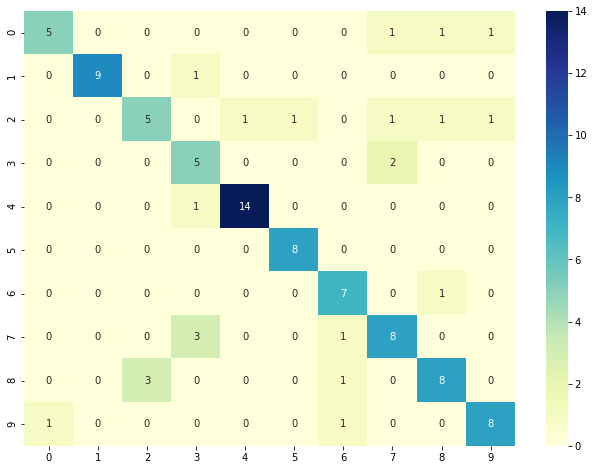

In [28]:
import json
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def create_conf_matrix(expected, predicted, n_classes):
    cm = [[0] * n_classes for i in range(n_classes)]
    for pred, exp in zip(predicted, expected):
        cm[pred][exp] += 1
    return cm

def calc_accuracy(conf_matrix):
    t = sum(sum(l) for l in conf_matrix)
    return sum(conf_matrix[i][i] for i in range(len(conf_matrix))) / t

prediction_file = 'predictions.jsonl'
result = None

# Loading the .jsonl file as a json object
with open(prediction_file) as f:
    result = [json.loads(jline) for jline in f.read().splitlines()]

# Inverting the mapping defined in the Dataset preparation for training
inv_mapping = {v: k for k, v in mapping.items()}

# Creating a list of predicted classes for each line starting the 1st class at 0
predicted = []
for i in range(len(result)):
    class_name = result[i]['Classes'][0]['Name']
    predicted.append(inv_mapping[class_name])
predicted = list(map(lambda x: x - 1, predicted))

# Creating a list of expected classes from the original test set
expected = originalValidationFrame[0].tolist()
expected = list(map(lambda x: x - 1, expected))

    
confusion_matrix = create_conf_matrix(expected, predicted, 10)
df_cm = pd.DataFrame(confusion_matrix, 
                     index = [i for i in "0123456789"],
                     columns = [i for i in "0123456789"])
plt.figure(figsize = (11, 8))
sn.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

print('Accuracy: {}'.format(calc_accuracy(confusion_matrix)))

TODISPLAY=5
i=0
print('Examples (first {}):'.format(TODISPLAY))
for index, row in originalValidationFrame.iterrows():
    print('Text: {}'.format(row['document']))
    print('Expected class: {}'.format(mapping[row[0]]))
    print('Results:')
    for j in range(len(result[i]['Classes'])):
        print(' • {0}: {1:.{2}f}'.format(result[i]['Classes'][j]['Name'], 
                                          result[i]['Classes'][j]['Score'], 2))
    print('')
    i = i + 1
    if i > TODISPLAY or i > len(result):
        break

### Real-Time analysis
<a id="RealtimeAnalysisCustomClassifier"></a>

#### Endpoint creation
<a id="EndpointCreation"></a>

You can create an endpoint so you can submit text to gain real-time insights into submitted content.

In [50]:
client = boto3.client('comprehend')
region = boto3.session.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

realtime_endpoint_name = document_classifier_name + '-endpoint'

try:
    response = client.create_endpoint(
        EndpointName=realtime_endpoint_name,
        ModelArn=document_classifier_arn,
        DesiredInferenceUnits=10
    )
    endpoint_arn = response['EndpointArn']
except ClientError as error:
    if error.response['Error']['Code'] == 'ResourceInUseException':
        print('An endpoint with the name "{0}" already exists. Hence not creating it.'.format(realtime_endpoint_name))
        endpoint_arn = 'arn:aws:comprehend:{0}:{1}:document-classifier-endpoint/{2}'.format(region, account_id, realtime_endpoint_name)


print('Document Classifier Endpoint ARN: ' + endpoint_arn)

An endpoint with the name "yahoo-answers-endpoint" already exists. Hence not creating it.
Document Classifier Endpoint ARN: arn:aws:comprehend:us-east-1:313506734225:document-classifier-endpoint/yahoo-answers-endpoint


Endpoint creation is an asynchronous process. You can get the endpoint's status polling the endpoint.

In [51]:
client = boto3.client('comprehend')

repeat = True
status = ''

while True:
    response = client.describe_endpoint(
        EndpointArn=endpoint_arn
    )
    status = response['EndpointProperties']['Status']
    if repeat:
        if status != 'CREATING' and status != 'UPDATING':
            break
        else:
            print('.', end = '')
            time.sleep(20) 
    else:
        break

print('Job status: ' + status)

Job status: IN_SERVICE


#### Real-Time Custom Classification
<a id="RunningEndpointClassification"></a>

In the following sample, you iterate over an array of sentences. For each example, you call the endpoint and display the results.

In [236]:
client = boto3.client('comprehend')

examples = [
    'What is the best investment strategy to follow during election time?',
    'What are the pros and cons of Montessori?',
    'What is the difference between Python and C++?',
    'What is the most beautiful place in eastern Europe?',
    'Can you tel me the difference between machine learning and artificial intelligence?',
    'What is the best way to deploy micro-services architectures on AWS?',
    'Two cows are standing in a field. One says to the other: "Are you worried about Mad Cow disease?" The other one says: "No, It doesn\'t worry me, I\'m a horse!"'
]

for i in range(0, len(examples)):
    response = client.classify_document(
        Text=examples[i],
        EndpointArn=endpoint_arn
    )
    print('Example: "{}"'.format(examples[i]))
    for i in range(0, 3):
        print('• #{0}: {1} (score {2:.{3}f})'.format(i + 1,
                                                     response['Classes'][i]['Name'],
                                                     response['Classes'][i]['Score'], 2))

Example: "What is the best investment strategy to follow during election time?"
• #1: BUSINESS_AND_FINANCE (score 0.90)
• #2: POLITICS_AND_GOVERNMENT (score 0.07)
• #3: EDUCATION_AND_REFERENCE (score 0.02)
Example: "What are the pros and cons of Montessori?"
• #1: EDUCATION_AND_REFERENCE (score 0.95)
• #2: COMPUTERS_AND_INTERNET (score 0.01)
• #3: SCIENCE_AND_MATHEMATICS (score 0.01)
Example: "What is the difference between Python and C++?"
• #1: COMPUTERS_AND_INTERNET (score 0.95)
• #2: EDUCATION_AND_REFERENCE (score 0.05)
• #3: SCIENCE_AND_MATHEMATICS (score 0.00)
Example: "What is the most beautiful place in eastern Europe?"
• #1: SOCIETY_AND_CULTURE (score 0.45)
• #2: BUSINESS_AND_FINANCE (score 0.19)
• #3: EDUCATION_AND_REFERENCE (score 0.12)
Example: "Can you tel me the difference between machine learning and artificial intelligence?"
• #1: COMPUTERS_AND_INTERNET (score 0.72)
• #2: EDUCATION_AND_REFERENCE (score 0.24)
• #3: SCIENCE_AND_MATHEMATICS (score 0.02)
Example: "What is t

#### Endpoint public API
<a id="OpeningEndpoint"></a>

Now you want others - outside of your AWS Account - being able to call your endpoint with your custom model. 

To open that custom model to the world, you can build an API that internally will call your Amazon Comprehend custom endpoint. This can be done with services such as Amazon API Gateway and AWS Lambda. 

[Amazon API Gateway](https://aws.amazon.com/api-gateway/getting-started/) is a fully managed service that makes it easy for developers to create, publish, maintain, monitor, and secure APIs at any scale. APIs act as the "front door" for applications to access data, business logic, or functionality from your backend services.

[AWS Lambda](https://aws.amazon.com/lambda/getting-started/) lets you run code without provisioning or managing servers. You pay only for the compute time you consume.

A typical serverless architecture:

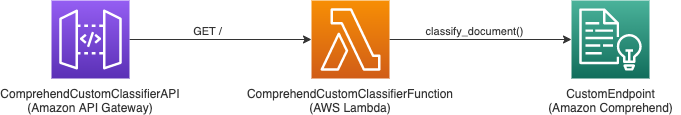

You can build and deploy this architecture with a tool such as [AWS SAM](https://docs.aws.amazon.com/serverless-application-model/latest/developerguide/serverless-getting-started.html).

You can deploy your own api following the `README.md` file in the `comprehend-custom-classifier-api` folder and replace both url and token in the following section.

In [47]:
import requests
from IPython.display import JSON

url = 'https://xxxxxxx.execute-api.us-east-1.amazonaws.com/Prod/classify/'
params = {'text': 'Could you please describe the feeling of achieving a goal really fast?'}
headers = {'x-api-key': 'XXXXXXXXXXXXXX'}

response = requests.get(url, params=params, headers=headers)
results = response.json()
print('Given Text: "{}"'.format(params['text']))
for i in range(0, 3):
    print('• #{0}: {1} (score {2:.{3}f})'.format(i + 1,
                                                 results[i]['Name'],
                                                 results[i]['Score'], 2))

Given Text: "Could you please describe the feeling of achieving a goal really fast?"
• #1: EDUCATION_AND_REFERENCE (score 0.68)
• #2: SOCIETY_AND_CULTURE (score 0.17)
• #3: BUSINESS_AND_FINANCE (score 0.08)


### Cleanup
<a id="CleanupCustomClassifier"></a>

In [ ]:
# Delete SAM Application if deployed
# Delete Realtime analysis Endpoint
# Delete Model
# Delete Bucket
# Delete Role

### Cost
<a id="CostCustomClassifier"></a>

On October 2020, Amazon Comprehend [pricing](https://aws.amazon.com/comprehend/pricing/) is as follow for the us-east-1 region:

- Model training: \\$3.0 per hour + \\$0.5 per month for model management
- Asynchronous processing: \$0.0005 per unit of 100 characters, with a 3 unit (300 character) minimum charge per request
- Real-Time processing: \$0.0005 per IU per second, one inference unit (IU) provides a throughput of 100 characters/second

In [33]:
training_duration_hours = 20
model_hosting_duration_months = 1
endpoint_hosting_duration_hours = 2
endpoint_hosting_inference_units = 10

async_size_unit = sum(originalValidationFrame['document'].str.len()) / 100

print('Total cost ${0:.{1}f} full data set'.format(3 * training_duration_hours + 
                                                   0.5 * model_hosting_duration_months +
                                                   0.0005 * async_size_unit +
                                                   0.0005 * endpoint_hosting_duration_hours * 60 * 60 * endpoint_hosting_inference_units, 1))

Total cost $96.8


## What's next?
<a id="WhatsNext"></a>

*([back to top](#TOC))*

### Auto Scale your Amazon Comprehend endpoints
<a id="AutoScaling"></a>

Instead of manually adjusting the number of inference units provisioned for your document classification endpoints and entity recognizer endpoints, you can use auto scaling to automatically set endpoint provisioning to fit your capacity needs.

You can achieve this leveraging [AWS Auto Scaling](https://aws.amazon.com/autoscaling/), a web service for developers and system administrators who need a solution for automatically scaling their scalable resources.

You have two ways to set auto scaling:

- Target Tracking
- Scheduled Scaling

To know more about auto scaling your endpoints, please refer to the [documentation](https://docs.aws.amazon.com/comprehend/latest/dg/comprehend-autoscaling.html).

### Annotate your data with Amazon Sagemaker Groundtruth
<a id="AnnotateYourData"></a>

In the following notebook, we used already labelled data. This is rarely the case, and you need to annotate your data for training Amazon Comprehend.

[Amazon SageMaker Ground Truth](https://aws.amazon.com/sagemaker/groundtruth/) is a fully managed data labeling service that makes it easy to build highly accurate training datasets for machine learning and [reduce labeling costs by up to 70%](https://aws.amazon.com/blogs/aws/amazon-sagemaker-ground-truth-build-highly-accurate-datasets-and-reduce-labeling-costs-by-up-to-70/).

You can now train Custom Named Entity Recognition and Custom Classification models wit Amazon Comprehend using training datasets annotated with [Amazon Sagemaker GroundTruth](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-label-text.html):

- [Named Entity Recognition](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-named-entity-recg.html)
- [Text Classification (Single Label)](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-text-classification.html)
- [Text Classification (Multi-label)](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-text-classification-multilabel.html)



### Amazon Comprehend Medical
<a id="Medical"></a>

[Amazon Comprehend Medical](https://aws.amazon.com/comprehend/medical/) is a natural language processing service that makes it easy to use machine learning to extract relevant medical information from unstructured text. Using Amazon Comprehend Medical, you can quickly and accurately gather information, such as medical condition, medication, dosage, strength, and frequency from a variety of sources like doctors’ notes, clinical trial reports, and patient health records. Amazon Comprehend Medical can also link the detected information to medical ontologies such as `ICD-10-CM` or `RxNorm` so it can be used easily by downstream healthcare applications.

Amazon Comprehend Medical proposes a separated set of APIs, if you want to know more about it, please refer to [Text Analysis APIs](https://docs.aws.amazon.com/comprehend/latest/dg/text-analysis-apis-med.html) and [Ontology Linking APIs](https://docs.aws.amazon.com/comprehend/latest/dg/ontology-linking-apis-med.html) (documentation for [Python](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/comprehendmedical.html)).

### AWS Solutions using Amazon Comprehend
<a id="Solutions"></a>

This section illustrates with two examples that can be built on top of AWS high level machine learning services.

#### Analyzing Text with Amazon Elasticsearch Service and Amazon Comprehend
<a id='SolutionESComprehend'></a>

This [solution](https://aws.amazon.com/solutions/implementations/analyzing-text-with-amazon-elasticsearch-service-and-amazon-comprehend/) leverages Amazon Elasticsearch Service, Amazon Comprehend, Amazon API Gateway, and AWS Lambda for extracting meaningful insights from unstructured data such as customer calls, support tickets, and online customer feedback. 

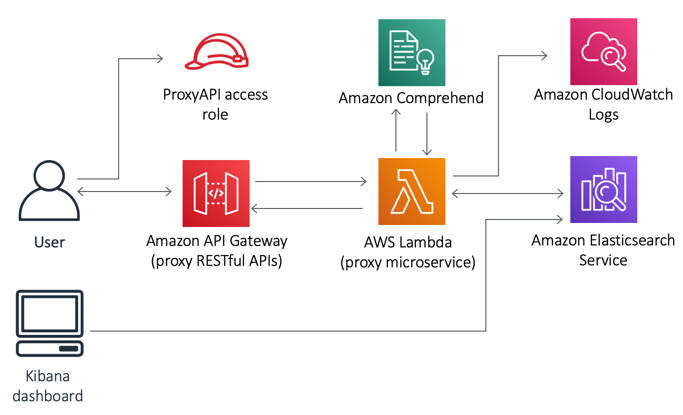

#### Document Understanding Solution (DUS)
<a id='SolutionDocumentUnderstanding'></a>

This [solution](https://aws.amazon.com/solutions/implementations/document-understanding-solution/) leverages Amazon Textract, Amazon Comprehend , Amazon Comprehend Medical, Amazon Elasticsearch and Amazon Kendra to provide digitization, domain-specific data discovery, redaction controls, structural component extraction and other document processing & understanding capaibilities.

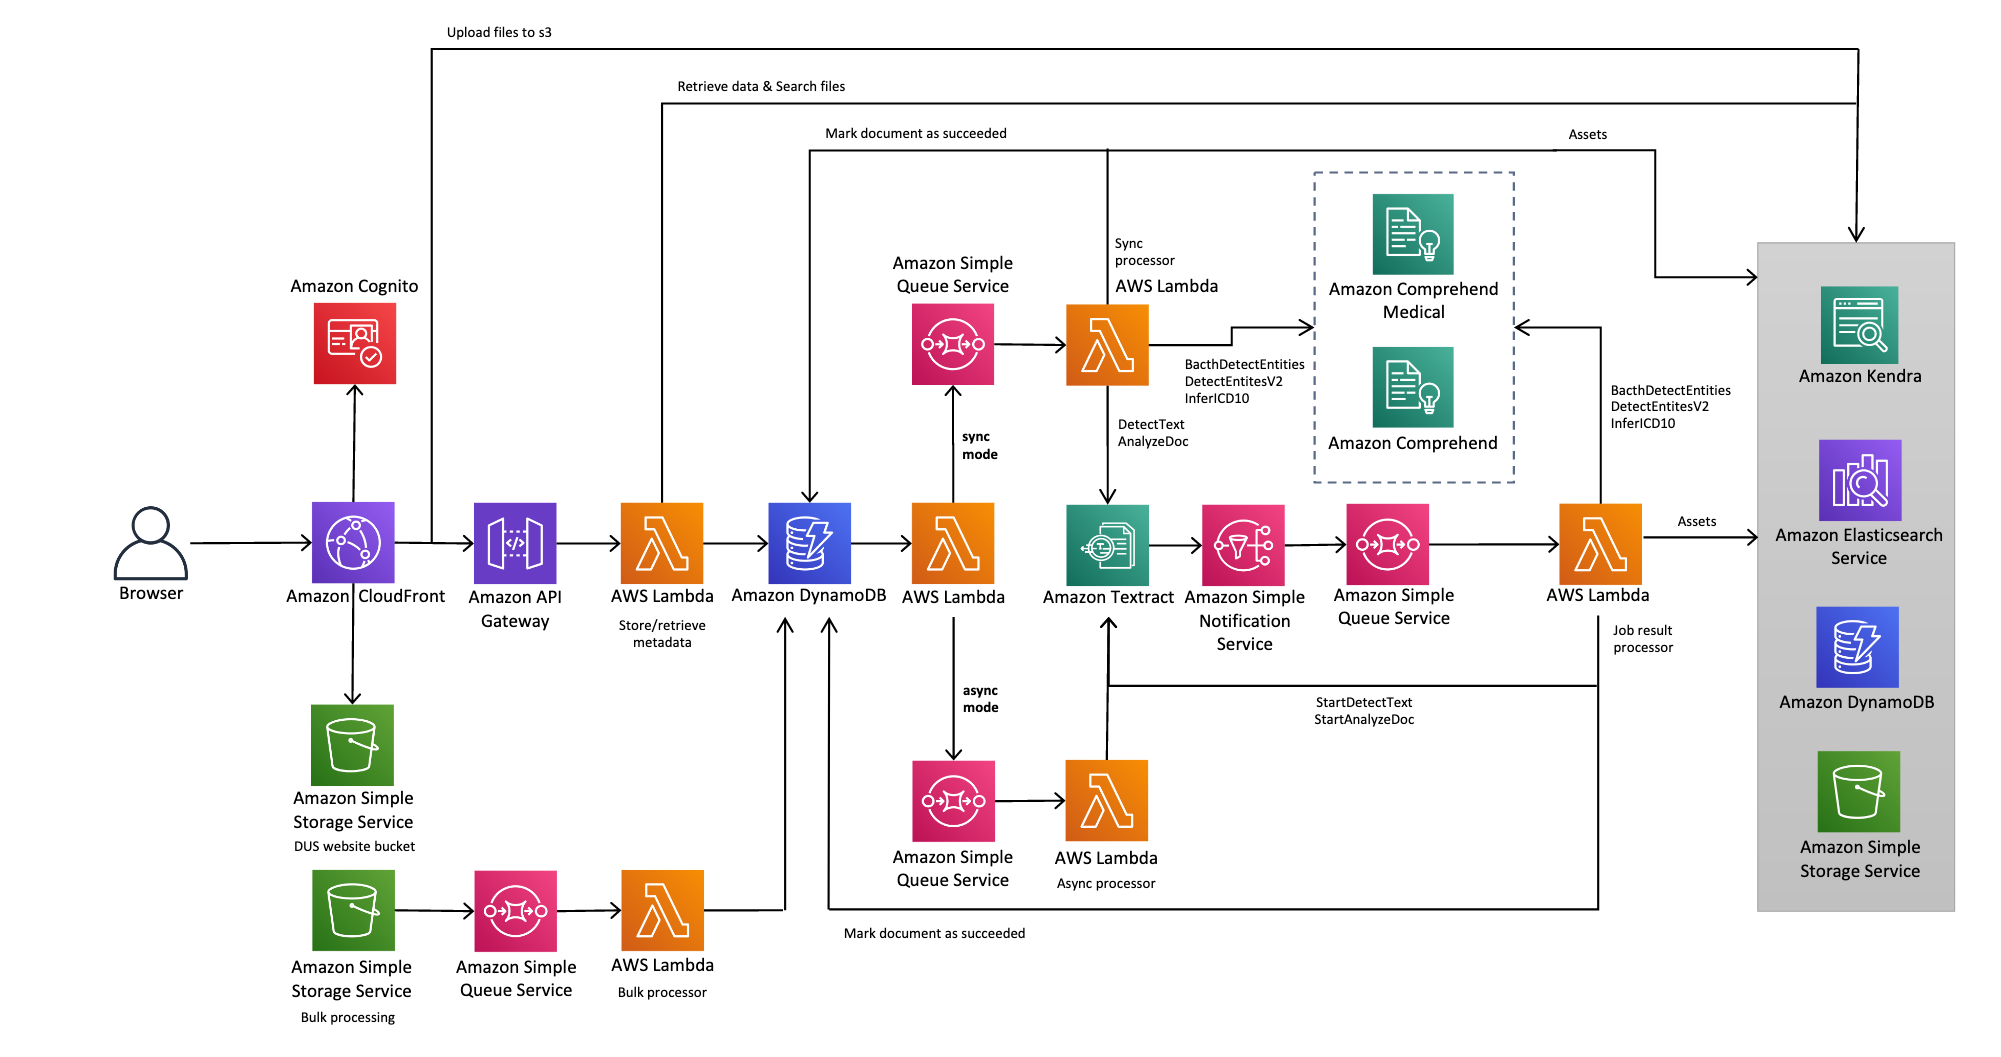